# Detect spots and clusters
* Full code in the first cell
* Segments of code for testing in cells 2,3,4,..

## TODO
* Incorporate nuclear and cell segmentation with cellpose

# COVID smFISH code

In [ ]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
import numpy as np
import tifffile
#from cellpose import models, io
from skimage.morphology import white_tophat, black_tophat, disk
import time

print("Big-FISH version: {0}".format(bigfish.__version__))

# hard-code the input/output directories
indir = os.path.join(os.getcwd(), 'DECODE/data')
infiles = [x for x in os.listdir(indir) if x.endswith('.tif')]
path_output = os.path.join(indir,'detections')

# get acquisition parameters
def img_params(file_name):
    if 'sgg' in file_name:
        voxel_size_z = 350
        voxel_size_yx = 139
        return voxel_size_z, voxel_size_yx
    if 'rab' or 'dlg' in file_name:
        voxel_size_z = 300
        voxel_size_yx = 139
        return voxel_size_z, voxel_size_yx
    else:
        voxel_size_z = 200
        voxel_size_yx = 139
        return voxel_size_z, voxel_size_yx        
#psf_z = 350
#psf_yx = 150

# calculate psf (thank you MK), with edit for consistent nomenclature 
def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    '''
    Use the formula implemented in Matlab version (sigma_PSF_BoZhang_v1)
    to calculate the theoretical PSF size.
    '''
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
        #original matlab code commented below:
        #widefield:
        #sigma_xy = 0.225 * lambda_em / NA ;
        #sigma_z  = 0.78 * RI * lambda_em / (NA*NA) ;
        #confocal/nipkow
        #sigma_xy = 0.225 / NA * lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
        #sigma_z =  0.78 * RI / (NA^2) *  lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()
    return psf_z, psf_yx

# convert OMERO Image object into np array
def get_z_stack(img, c, t=0):
    z_range = range(0, img.getSizeZ(), 1)
    zct_list = [(z, c, t) for z in z_range]
    pixels = img.getPrimaryPixels()
    return np.array(list(pixels.getPlanes(zct_list)))
        
# analyze all images in a dataset
start_time = time.time()
print ('processing ', file_name)
img = tifffile.imread(os.path.join(indir,file_name))
print ("file loading took ", time.time() - start_time, "sec")

'''
# segment with cellpose
if 'R1' in file_name:
    seg_img = np.max(img[:,2],0)
    seg_img = np.clip(seg_img,0,200)
else:
    seg_img = np.max(img[:,1],0)
model = models.Cellpose(gpu=False, model_type='cyto')
channels = [0,0]
masks, flows, styles, diams = model.eval(seg_img, channels=channels, diameter=375, do_3D=False)
'''

def detect_spots(chan, ch):
    rna = np.swapaxes(img,0,1)[chan]

    # subtract background 
    def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)

    rna_no_bg = []
    for z in rna:
        z_no_bg = subtract_background(z)
        rna_no_bg.append(z_no_bg)
    rna = np.array(rna_no_bg)

    # calculate_psf(voxel_size_z, voxel_size_yx, 570, 610, 1.4, 1.364, 'confocal')[0]
    psf_z = calculate_psf(img_params(file_name)[0], img_params(file_name)[1], 
                          570, 610, 1.4, 1.364, 'confocal')[0]
    psf_yx = calculate_psf(img_params(file_name)[0], img_params(file_name)[1], 
                          570, 610, 1.4, 1.364, 'confocal')[1]
    sigma_z, sigma_yx, sigma_yx = detection.get_sigma(img_params(file_name)[0], 
                                    img_params(file_name)[1], psf_z, psf_yx)            
    sigma = (sigma_z, sigma_yx, sigma_yx)

    # LoG filter
    rna_log = stack.log_filter(rna, sigma)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=sigma)
    
    threshold = 200
    #threshold = detection.automated_threshold_setting(rna_log, mask)
    spots, _ = detection.spots_thresholding(rna_log, mask, threshold)

    # detect and decompose clusters
    spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
    rna, spots, 
    img_params(file_name)[0], img_params(file_name)[1], psf_z, psf_yx,
    alpha=0.7,  # alpha impacts the number of spots per cluster
    beta=1)   # beta impacts the number of detected clusters

    # separate spots from clusters
    radius = 350
    nb_min_spots = 4
    spots_post_clustering, foci = detection.detect_foci(spots_post_decomposition, 
        img_params(file_name)[0], img_params(file_name)[1], radius, nb_min_spots)

    # extract cell level results
    image_contrasted = stack.rescale(rna, channel_to_stretch=0)
    image_contrasted = stack.maximum_projection(image_contrasted)
    rna_mip = stack.maximum_projection(rna)

    fov_results = stack.extract_cell(
        cell_label=masks.astype(np.int64),  # masks is the cellpose segmentation
        ndim=3, 
        rna_coord=spots_post_clustering, 
        others_coord={"foci": foci},
        image=image_contrasted,
        others_image={"smfish": rna_mip})

    # save results
    for i, cell_results in enumerate(fov_results):
        path = os.path.join(path_output, file_name.split('.')[0]+'_'+ch+'_results_cell_{0}.npz'.format(i))
        stack.save_cell_extracted(cell_results, path)
    print ("bigfish analysis took ", time.time() - start_time, "sec")

detect_spots(2, 'ch3')
detect_spots(3, 'ch4')


print ('FINISHED!')


In [23]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
import numpy as np
from skimage.morphology import white_tophat, black_tophat, disk
print("Big-FISH version: {0}".format(bigfish.__version__))

# hard-code the paths of our input and output directories
path_input = "DECODE/data/"
path_files = [x for x in os.listdir(path_input) if x.endswith('.tif')]
path_output = "detections/"

# get acquisition parameters

def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    '''
    Use the formula implemented in Matlab version (sigma_PSF_BoZhang_v1)
    to calculate the theoretical PSF size.
    '''
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
        #original matlab code commented below:
        #widefield:
        #sigma_xy = 0.225 * lambda_em / NA ;
        #sigma_z  = 0.78 * RI * lambda_em / (NA*NA) ;
        #confocal/nipkow
        #sigma_xy = 0.225 / NA * lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
        #sigma_z =  0.78 * RI / (NA^2) *  lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;

    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()

    return psf_z, psf_yx

voxel_size_z = 300
voxel_size_yx = 139
#psf_z = 350
#psf_yx = 150
psf_z, psf_yx = calculate_psf(voxel_size_z, voxel_size_yx, 570, 610, 1.4, 1.364, 'nipkow')

sigma_z, sigma_yx, sigma_yx = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
sigma = (sigma_z, sigma_yx, sigma_yx)
    
for file in path_files:
    path = os.path.join(path_input, file)
    image = stack.read_image(path)
    
    # subtract background 
    def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)

    rna_no_bg = []
    
    for z in image:
        z_no_bg = subtract_background(z)
        rna_no_bg.append(z_no_bg)
    rna = np.array(rna_no_bg)
    
    # Detect spots

    # LoG filter
    rna_log = stack.log_filter(rna, sigma)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=sigma)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    #threshold = 350
    spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
    
    # save plot of the detections
    (radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
    rna_mip = stack.maximum_projection(rna)
    
    # detect and decompose clusters
    spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
    rna, spots, 
    voxel_size_z, voxel_size_yx, psf_z, psf_yx,
    alpha=0.7,  # alpha impacts the number of spots per cluster
    beta=1)   # beta impacts the number of detected clusters

    '''
    plot.plot_detection(rna_mip, 
                spots=[spots_post_decomposition, foci[:, :3]], 
                shape=["circle", "polygon"], 
                radius=[radius_yx, radius_yx*2], 
                color=["red", "blue"],
                linewidth=[1, 2], 
                fill=[False, True], 
                framesize=(10, 8), 
                contrast=True,
                path_output=os.path.join(path_output,os.path.splitext(file)[0]+'_detections'),
                ext="png", 
                show=False)
    '''   
    # separate spots from clusters
    radius = 350
    nb_min_spots = 4
    spots_post_clustering, foci = detection.detect_foci(spots_post_decomposition, 
        voxel_size_z, voxel_size_yx, radius, nb_min_spots)
    
    print (file, len(spots_post_clustering), len(foci))
    # save in csv files
    path = os.path.join(path_output,os.path.splitext(file)[0]+'_spots.csv')
    stack.save_data_to_csv(spots_post_clustering, path)
    path = os.path.join(path_output,os.path.splitext(file)[0]+'_clusters.csv')
    stack.save_data_to_csv(foci, path)
    

Big-FISH version: 0.4.0


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

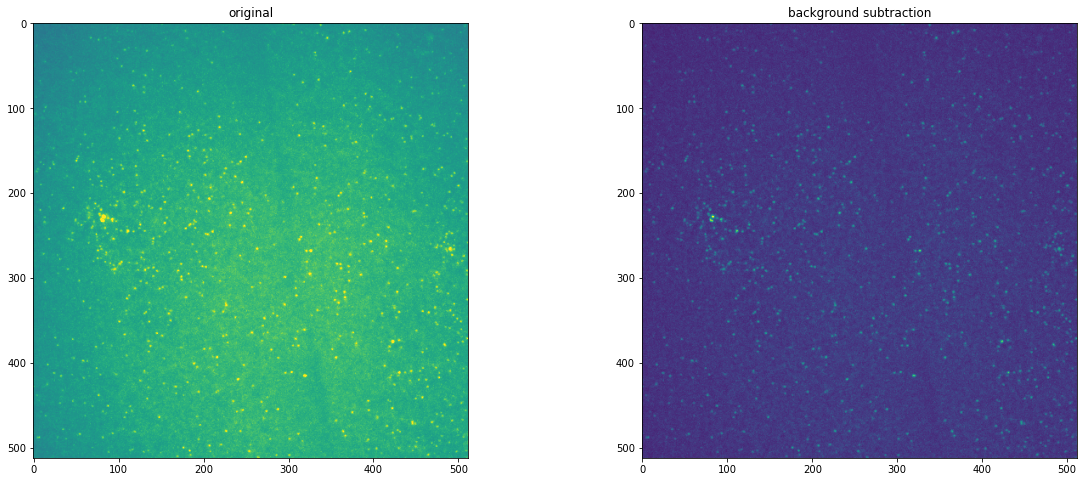

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
ax[0].set_title('original')
ax[0].imshow(np.max(image,0), vmin=0, vmax=15000)
ax[1].set_title('background subtraction')
ax[1].imshow(np.max(rna, 0), vmin=0, vmax=15000)

plt.show()

# Notes on the dataset
## Spot detection
* autothreshold works reasonably well for all images except sgg_smFISH_4.tif and sgg_smFISH_2.tif
    * typical values are around 75, but the algorithm defines a threshold of > 400 for those images

# Quick view of detections

In [5]:
import os
import bigfish.stack as stack

# hard-code the paths of our input and output directories
path_input = "DECODE/data"
file = 'sgg_smFISH_2.tif'
path = os.path.join(path_input, file)
rna = stack.read_image(path)

# get acquisition parameters
voxel_size_z = 350
voxel_size_yx = 139
#psf_z = 350
#psf_yx = 150
calculate_psf(voxel_size_z, voxel_size_yx, 670, 710, 1.4, 1.364, 'nipkow')

sigma_z, sigma_yx, sigma_yx = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
sigma = (sigma_z, sigma_yx, sigma_yx)
    
# Detect spots

# LoG filter
rna_log = stack.log_filter(rna, sigma)

# local maximum detection
mask = detection.local_maximum_detection(rna_log, min_distance=sigma)

# thresholding
#threshold = detection.automated_threshold_setting(rna_log, mask)
threshold = 78
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)

#(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
#rna_mip = stack.maximum_projection(rna)
#plot.plot_detection(rna_mip, spots, radius=radius_yx, framesize=(10, 8), contrast=True)

# detect and decompose clusters
spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
rna, spots, 
voxel_size_z, voxel_size_yx, psf_z, psf_yx,
alpha=0.7,  # alpha impacts the number of spots per cluster
beta=1)   # beta impacts the number of detected clusters

# separate spots from clusters
radius = 350
nb_min_spots = 4
spots_post_clustering, foci = detection.detect_foci(spots_post_decomposition, 
    voxel_size_z, voxel_size_yx, radius, nb_min_spots)

(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
rna_mip = stack.maximum_projection(rna)
#plot.plot_detection(rna_mip, spots, radius=radius_yx, framesize=(10, 8), contrast=True)
plot.plot_detection(rna_mip, 
                    spots=[spots_post_decomposition, foci[:, :3]], 
                    shape=["circle", "polygon"], 
                    radius=[radius_yx, radius_yx*2], 
                    color=["red", "blue"],
                    linewidth=[1, 2], 
                    fill=[False, True], 
                    framesize=(10, 8), 
                    contrast=True,
                    path_output=os.path.join(path_output,os.path.splitext(file)[0]+'_detections'),
                    ext="png", 
                    show=True)

print (file, len(spots_post_clustering), len(foci))
# save in csv files
path = os.path.join(path_output,os.path.splitext(file)[0]+'_spots.csv')
stack.save_data_to_csv(spots_post_clustering, path)
path = os.path.join(path_output,os.path.splitext(file)[0]+'_clusters.csv')
stack.save_data_to_csv(foci, path)

def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    '''
    Use the formula implemented in Matlab version (sigma_PSF_BoZhang_v1)
    to calculate the theoretical PSF size.
    '''
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
        #original matlab code commented below:
        #widefield:
        #sigma_xy = 0.225 * lambda_em / NA ;
        #sigma_z  = 0.78 * RI * lambda_em / (NA*NA) ;
        #confocal/nipkow
        #sigma_xy = 0.225 / NA * lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
        #sigma_z =  0.78 * RI / (NA^2) *  lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;

    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()

    return psf_z, psf_yx

NameError: name 'calculate_psf' is not defined

In [81]:
plot.plot_detection()

79.0

radius z axis: 2.021
radius yx axis: 1.869
smfish channel (2D maximum projection)
 shape: (512, 512)
 dtype: uint16


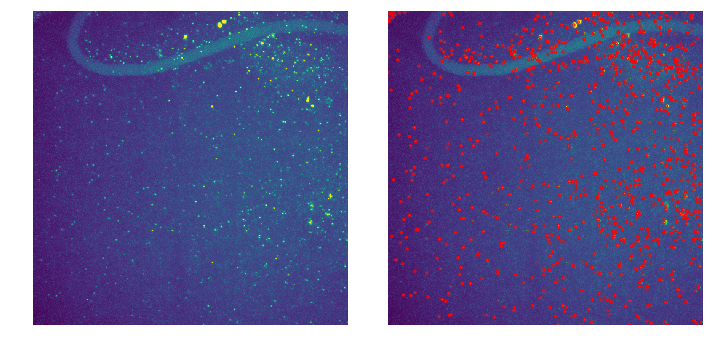

<Figure size 432x288 with 0 Axes>

In [40]:
(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
print("radius z axis: {0:0.3f}".format(radius_z))
print("radius yx axis: {0:0.3f}".format(radius_yx))
rna_mip = stack.maximum_projection(rna)
print("smfish channel (2D maximum projection)")
print("\r shape: {0}".format(rna_mip.shape))
print("\r dtype: {0}".format(rna_mip.dtype))
plot.plot_detection(rna_mip, spots, radius=radius_yx, framesize=(10, 8), contrast=True)
plot.utils.save_plot('detections', 'png')

In [1]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
import numpy as np
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.4.0


In [2]:
# hard-code the paths of our input and output directories
path_input = "data/"
path_output = "detections/"

# check input images are loaded
stack.check_input_data(path_input)


#path = os.path.join(path_input, "Dlg1_smFISH_1.tif")
#nuc = stack.read_image(path)
#print("dapi channel")
#print("\r shape: {0}".format(nuc.shape))
#print("\r dtype: {0}".format(nuc.dtype))

path = os.path.join(path_input, "Dlg1_smFISH_1.tif")
rna = stack.read_image(path)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

downloading experiment_1_dapi_fov_1.tif...
downloading experiment_1_smfish_fov_1.tif...
smfish channel
 shape: (84, 512, 512)
 dtype: uint16


In [11]:
# parameters
voxel_size_z = 300
voxel_size_yx = 139
#psf_z = 350
#psf_yx = 150

def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    '''
    Use the formula implemented in Matlab version (sigma_PSF_BoZhang_v1)
    to calculate the theoretical PSF size.
    '''
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
        #original matlab code commented below:
        #widefield:
        #sigma_xy = 0.225 * lambda_em / NA ;
        #sigma_z  = 0.78 * RI * lambda_em / (NA*NA) ;
        #confocal/nipkow
        #sigma_xy = 0.225 / NA * lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
        #sigma_z =  0.78 * RI / (NA^2) *  lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;

    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()

    return psf_z, psf_yx
calculate_psf(voxel_size_z, voxel_size_yx, 570, 610, 1.4, 1.364, 'nipkow')

# sigma
sigma_z, sigma_yx, sigma_yx = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
print("standard deviation of the PSF (z axis): {:0.3f} pixels".format(sigma_z))
print("standard deviation of the PSF (yx axis): {:0.3f} pixels".format(sigma_yx))

sigma = (sigma_z, sigma_yx, sigma_yx)

standard deviation of the PSF (z axis): 1.167 pixels
standard deviation of the PSF (yx axis): 1.079 pixels


In [12]:
# Detect spots

# LoG filter
rna_log = stack.log_filter(rna, sigma)

# local maximum detection
mask = detection.local_maximum_detection(rna_log, min_distance=sigma)

# thresholding
threshold = detection.automated_threshold_setting(rna_log, mask)
#threshold = 350
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (1014, 3)
 dtype: int64
 threshold: 783.0


radius z axis: 2.021
radius yx axis: 1.869
smfish channel (2D maximum projection)
 shape: (512, 512)
 dtype: uint16


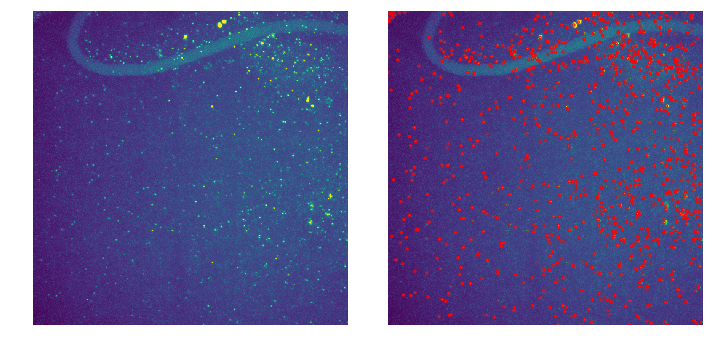

In [13]:
(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
print("radius z axis: {0:0.3f}".format(radius_z))
print("radius yx axis: {0:0.3f}".format(radius_yx))
rna_mip = stack.maximum_projection(rna)
print("smfish channel (2D maximum projection)")
print("\r shape: {0}".format(rna_mip.shape))
print("\r dtype: {0}".format(rna_mip.dtype))
plot.plot_detection(rna_mip, spots, radius=radius_yx, framesize=(10, 8), contrast=True)

In [15]:
spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
    rna, spots, 
    voxel_size_z, voxel_size_yx, psf_z, psf_yx,
    alpha=0.7,  # alpha impacts the number of spots per cluster
    beta=1)   # beta impacts the number of detected clusters

print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (1014, 3)
 dtype: int64
detected spots after decomposition
 shape: (1368, 3)
 dtype: int64


In [61]:
radius = 350
nb_min_spots = 4
spots_post_clustering, foci = detection.detect_foci(
    spots_post_decomposition, 
    voxel_size_z, voxel_size_yx, radius, nb_min_spots)
print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype))
print("detected foci")
print("\r shape: {0}".format(foci.shape))
print("\r dtype: {0}".format(foci.dtype))

detected spots after clustering
 shape: (1368, 4)
 dtype: int64
detected foci
 shape: (8, 5)
 dtype: int64


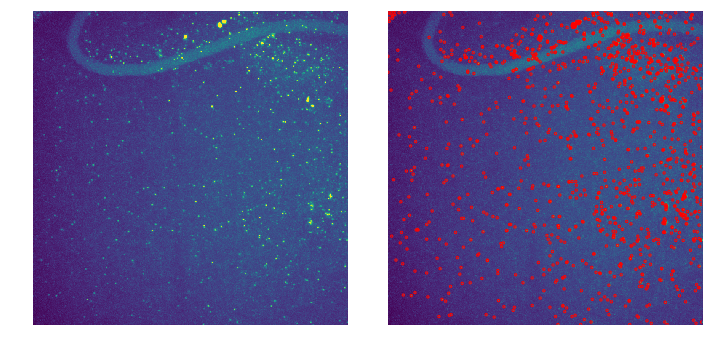

In [16]:
plot.plot_detection(rna_mip, spots_post_decomposition, radius=radius_yx, 
                    framesize=(10, 8), contrast=True)

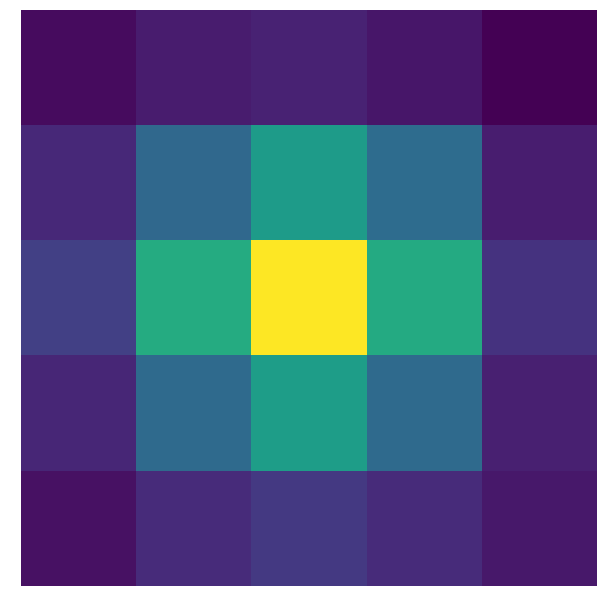

In [17]:
plot.plot_reference_spot(reference_spot, rescale=True)

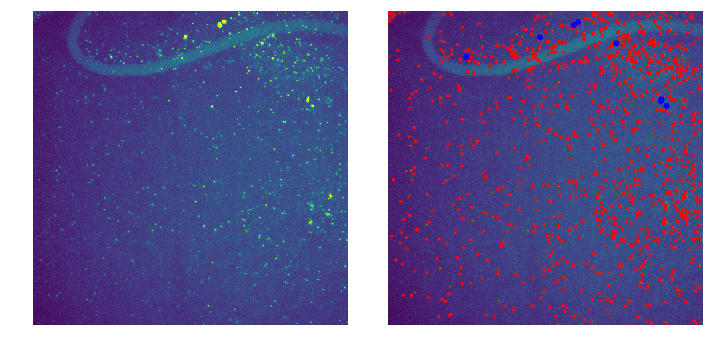

In [23]:
# plot
plot.plot_detection(rna_mip, 
                    spots=[spots_post_decomposition, foci[:, :3]], 
                    shape=["circle", "polygon"], 
                    radius=[radius_yx, radius_yx*2], 
                    color=["red", "blue"],
                    linewidth=[1, 2], 
                    fill=[False, True], 
                    framesize=(10, 8), 
                    contrast=True)